 Using CUDA GPU: NVIDIA GeForce RTX 5060
 Found 5320 files and 8 labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad', 'calm']
 Loading cached features from cached_features.pkl...


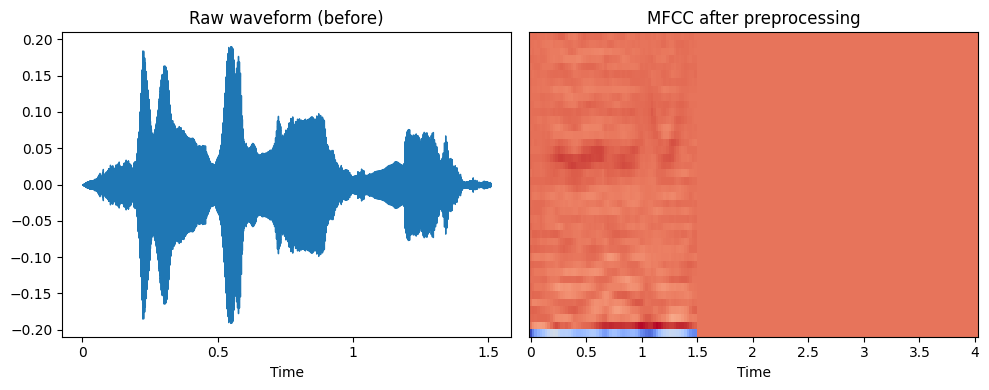

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\3234721896.py:346: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


 Loading saved model...
Loaded. Best val so far: 78.44611528822055


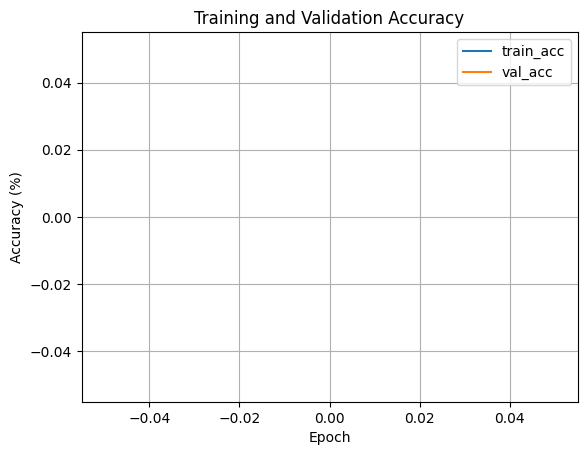


Running quick prediction on test file:
Predicted Emotion: disgust
Total labels (emotions): 8 -> ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad', 'calm']
Training history saved to training_history.pkl
✅ Using device: cuda


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\3234721896.py:391: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=='cuda')):


NameError: name 'model' is not defined

In [ ]:

import os
import random
import pickle
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models

# ---------------------------
# USER PATHS 
# ---------------------------
DATA_DIRS = [
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\voice_data\\train_data\\SER",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_01",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_02",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_03",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_04",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_05",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_06",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_07",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_08",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_09",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_10",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_11",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_12",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_13",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_14",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_15",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_16",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_17",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_18",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_19",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_20",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_21",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_22",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_23",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_24",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Angry",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Happy",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Natural",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Sad",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Surprised"
]
CACHE_PATH = r"cached_features.pkl"
MODEL_PATH = r"resnet_speech_final model.pth"
TEST_FILE = r"K:\Code\Project\Research Paper\Emotion Detection\voice_data\test_data\self.wav"

# ---------------------------
# HYPERPARAMETERS
# ---------------------------
SR = 22050
N_MFCC = 40
MAX_PAD_LEN = 174
BATCH_SIZE = 64
EPOCHS = 60
LR = 1e-4
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---------------------------
# DEVICE INFO
# ---------------------------
if DEVICE.type == "cuda":
    print(f" Using CUDA GPU: {torch.cuda.get_device_name(0)}")
else:
    print(" CUDA not available, using CPU instead.")

# ---------------------------
# FEATURE EXTRACTION
# ---------------------------

def extract_mfcc(path, sr=SR, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN, augment=False):
    """Load audio, optional simple augmentations, compute MFCC and pad/truncate to fixed length."""
    y, _ = librosa.load(path, sr=sr)

    # Save raw for before/after display if requested by caller
    raw = y.copy()

    if augment:
        # simple, fast augmentations; controlled probability
        if random.random() < 0.3:
            y = y + 0.005 * np.random.randn(len(y))
        if random.random() < 0.3:
            n_steps = random.choice([-2, -1, 1, 2])
            y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)
        if random.random() < 0.3:
            rate = random.uniform(0.9, 1.1)
            # time_stretch changes length; guard against tiny signals
            try:
                y = librosa.effects.time_stretch(y, rate)
            except Exception:
                pass

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # pad or truncate to shape (n_mfcc, max_pad_len)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    elif mfcc.shape[1] > max_pad_len:
        mfcc = mfcc[:, :max_pad_len]

    return mfcc, raw

# ---------------------------
# DATA LOADING / CACHING
# ---------------------------

def build_file_list(data_dirs):
    files = []
    emotions = []
    for d in data_dirs:
        if not os.path.exists(d):
            print(f" Warning: {d} not found, skipping")
            continue
        for name in os.listdir(d):
            if not name.lower().endswith('.wav'):
                continue
            # keep your labeling heuristic: label is last token before .wav
            label = name.split('_')[-1].replace('.wav', '')
            if label not in emotions:
                emotions.append(label)
            files.append((os.path.join(d, name), emotions.index(label)))
    return files, emotions


def compute_features(files, cache_path=CACHE_PATH, use_cache=True):
    if use_cache and os.path.exists(cache_path):
        print(f" Loading cached features from {cache_path}...")
        with open(cache_path, 'rb') as f:
            X, y, emotions = pickle.load(f)
        return X, y, emotions

    print(" Extracting MFCC features...")
    num_workers = max(1, multiprocessing.cpu_count() - 1)
    print(f" Using {num_workers} workers for extraction")

    def proc(item):
        path, lbl = item
        try:
            mfcc, _ = extract_mfcc(path, augment=True)
            return mfcc, lbl
        except Exception as e:
            print(f"Error {path}: {e}")
            return None

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        results = list(tqdm(ex.map(proc, files), total=len(files)))

    results = [r for r in results if r is not None]
    X, y = zip(*results)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)

    # recover emotions ordering from files list
    _, emotions = build_file_list([os.path.dirname(p) for p, _ in files])

    with open(cache_path, 'wb') as f:
        pickle.dump((X, y, emotions), f)
    print(f" Cached features to {cache_path}")
    return X, y, emotions

# ---------------------------
# DATASET
# ---------------------------
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        arr = self.X[idx]
        # (n_mfcc, frames) -> (1, n_mfcc, frames)
        arr = np.expand_dims(arr, 0)
        return torch.tensor(arr, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# ---------------------------
# MODEL
# ---------------------------
class ResNetLSTM(nn.Module):
    def __init__(self, num_emotions, pretrained=True):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        # freeze early layers for speed
        for name, p in resnet.named_parameters():
            if 'layer4' not in name:
                p.requires_grad = False
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.bn_res = nn.BatchNorm1d(512)
        # LSTM expects (batch, seq, features)
        self.lstm = nn.LSTM(512, 256, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(256 * 2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        # x: (B, 1, n_mfcc, frames) -> resize to image-like and convert to 3 channels
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = x.repeat(1, 3, 1, 1)
        feats = self.resnet(x)
        feats = self.bn_res(feats)
        # expand across time dimension (frames) to feed LSTM: (B, seq, feat)
        feats = feats.unsqueeze(1).repeat(1, MAX_PAD_LEN, 1)
        out, _ = self.lstm(feats)
        out = out[:, -1, :]
        return self.fc(out)

# ---------------------------
# TRAIN / EVAL UTILITIES
# ---------------------------

def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Training batches', leave=False)
    for Xb, yb in pbar:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            out = model(Xb)
            loss = criterion(out, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * Xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100*correct/total)

    return running_loss / total, 100.0 * correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation batches', leave=False)
        for Xb, yb in pbar:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * Xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            pbar.set_postfix(loss=running_loss/total, acc=100*correct/total)

    return running_loss / total, 100.0 * correct / total

# ---------------------------
# PLOTTING
# ---------------------------

def plot_before_after(raw_signal, mfcc, save_path=None):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(raw_signal, sr=SR)
    plt.title('Raw waveform (before)')
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc, sr=SR, x_axis='time')
    plt.title('MFCC after preprocessing')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_accuracy(history, save_path=None):
    epochs = np.arange(1, len(history['train_acc']) + 1)
    plt.figure()
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ---------------------------
# MAIN
# ---------------------------

def main():
    files, emotions = build_file_list(DATA_DIRS)
    if len(files) == 0:
        raise RuntimeError('No audio files found. Check DATA_DIRS')

    print(f" Found {len(files)} files and {len(emotions)} labels: {emotions}")

    X, y, emotions = compute_features(files, cache_path=CACHE_PATH, use_cache=True)

    # show one before/after for the first file (non-augmented for 'before')
    sample_path = files[0][0]
    mfcc_noaug, raw = extract_mfcc(sample_path, augment=False)
    mfcc_aug, _ = extract_mfcc(sample_path, augment=True)
    # display and save single before/after image
    plot_before_after(raw, mfcc_aug, save_path='mfcc resnet speech_output.png')

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y)
    train_ds = EmotionDataset(X_train, y_train)
    val_ds = EmotionDataset(X_val, y_val)

    num_workers = 0
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

    model = ResNetLSTM(num_emotions=len(emotions), pretrained=True).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)
    scaler = torch.cuda.amp.GradScaler()

    # load or train
    choice = input("Do you want to load the saved model? (yes/no): ").strip().lower()
    start_epoch = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val = -1.0
    train_loss_history = []
    if choice == 'yes' and os.path.exists(MODEL_PATH):
        print(' Loading saved model...')
        chk = torch.load(MODEL_PATH, map_location=DEVICE)
        model.load_state_dict(chk.get('model', chk))
        best_val = chk.get('best_val', best_val)
        print(f"Loaded. Best val so far: {best_val}")
    else:
        print(' Training from scratch...')
        for epoch in range(start_epoch, EPOCHS):
            print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
            val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
            scheduler.step(val_acc)

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
            train_loss_history.append(train_loss)
            # save best
            if val_acc > best_val:
                best_val = val_acc
                torch.save({'model': model.state_dict(), 'emotions': emotions, 'best_val': best_val}, MODEL_PATH)
                print(f" Saved best model (val_acc={best_val:.2f}%) to {MODEL_PATH}")

    # plot accuracy
    plot_accuracy(history, save_path='training_validation_accuracy resnet speech.png')

    # quick test prediction if test file exists
    if os.path.exists(TEST_FILE):
        print('\nRunning quick prediction on test file:')
        model.eval()
        mfcc, _ = extract_mfcc(TEST_FILE, augment=False)
        input_tensor = torch.tensor(np.expand_dims(mfcc, 0), dtype=torch.float32).unsqueeze(1).to(DEVICE)
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=='cuda')):
            out = model(input_tensor)
            pred = out.argmax(dim=1).item()
        print(f"Predicted Emotion: {emotions[pred]}")
    else:
        print(' Test file not found, skipping prediction')

    # show number of labels
    print(f"Total labels (emotions): {len(emotions)} -> {emotions}")

    # save history
    with open('training_history.pkl', 'wb') as f:
        pickle.dump(history, f)
    print('Training history saved to training_history.pkl')


if __name__ == '__main__':
    main()



 Using device: cuda
 Model loaded with 8 emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad', 'calm']


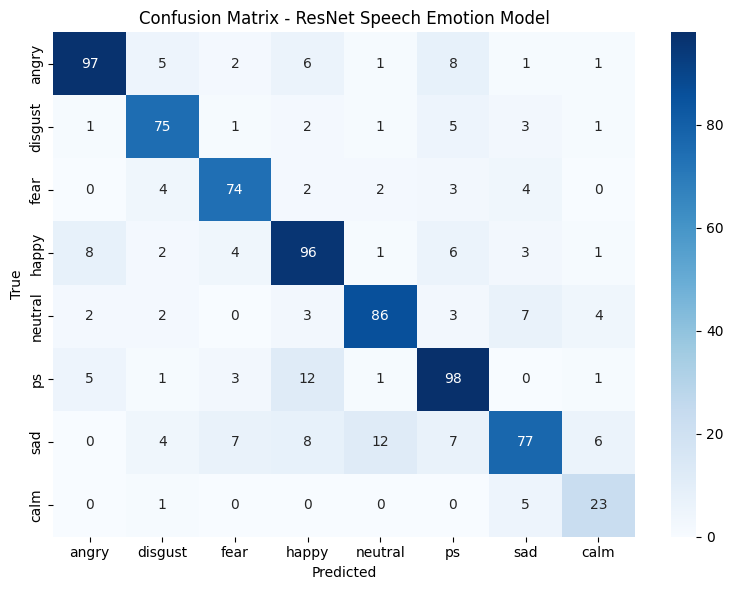

 Saved: confusion_matrix_resnet.png


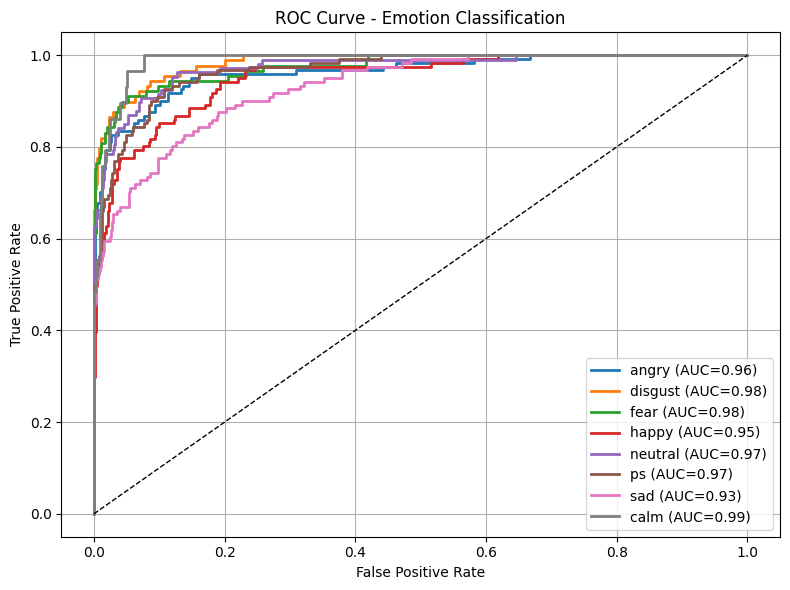

 Saved: roc_curve_resnet.png


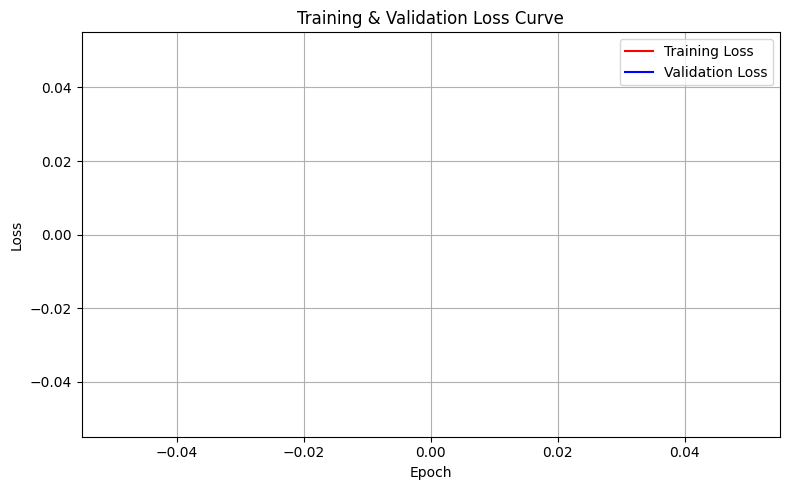

 Saved: training_loss_curve_resnet.png


In [11]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle
from torchvision import models
import torch.nn as nn

# =====================================================
# DEVICE SETUP
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")
torch.backends.cudnn.benchmark = True

# =====================================================
# MODEL DEFINITION (same as training)
# =====================================================
MAX_PAD_LEN = 174

class ResNetLSTM(nn.Module):
    def __init__(self, num_emotions, pretrained=True):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        for name, p in resnet.named_parameters():
            if 'layer4' not in name:
                p.requires_grad = False
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.bn_res = nn.BatchNorm1d(512)
        self.lstm = nn.LSTM(512, 256, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(256 * 2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = x.repeat(1, 3, 1, 1)
        feats = self.resnet(x)
        feats = self.bn_res(feats)
        feats = feats.unsqueeze(1).repeat(1, MAX_PAD_LEN, 1)
        out, _ = self.lstm(feats)
        out = out[:, -1, :]
        return self.fc(out)

# =====================================================
# LOAD MODEL CHECKPOINT
# =====================================================
MODEL_PATH = "resnet_speech_final model.pth"
checkpoint = torch.load(MODEL_PATH, map_location=device)
emotions = checkpoint["emotions"]
num_emotions = len(emotions)

model = ResNetLSTM(num_emotions=num_emotions, pretrained=False).to(device)
model.load_state_dict(checkpoint["model"])
model.eval()

print(f" Model loaded with {num_emotions} emotion classes: {emotions}")

# =====================================================
# LOAD TEST DATA (from your cached features)
# =====================================================
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        arr = np.expand_dims(self.X[idx], 0)
        return torch.tensor(arr, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# Load cached features (created during training)
with open("cached_features.pkl", "rb") as f:
    X, y, _ = pickle.load(f)

# Split last 15% as test set (same as in training)
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

test_loader = DataLoader(EmotionDataset(X_test, y_test), batch_size=32, shuffle=False)

# =====================================================
# COLLECT PREDICTIONS
# =====================================================
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# =====================================================
# CONFUSION MATRIX
# =====================================================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet Speech Emotion Model")
plt.tight_layout()
plt.savefig("confusion_matrix_resnet_speech.png")
plt.show()
print(" Saved: confusion_matrix_resnet.png")

# =====================================================
# ROC CURVE (multi-class)
# =====================================================
y_bin = label_binarize(all_labels, classes=list(range(num_emotions)))

plt.figure(figsize=(8, 6))
for i in range(num_emotions):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{emotions[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Emotion Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_resnet_speech.png")
plt.show()
print(" Saved: roc_curve_resnet.png")

# =====================================================
# TRAINING LOSS CURVE (if available)
# =====================================================
if os.path.exists("training_history.pkl"):
    with open("training_history.pkl", "rb") as f:
        history = pickle.load(f)

    plt.figure(figsize=(8, 5))
    plt.plot(history["train_loss"], label="Training Loss", color="red")
    plt.plot(history["val_loss"], label="Validation Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("training_loss_curve_resnet_speech.png")
    plt.show()
    print(" Saved: training_loss_curve_resnet.png")
else:
    print("⚠️ training_history.pkl not found. Run training once to generate it.")


In [1]:
import torch
torch.cuda.is_available()


True